# Derin Öğrenme ile Zaman Serileri Analizi Ve Tahmini

Tarihsel olarak **altın**, ABD dahil dünyanın çeşitli yerlerinde bir para birimi olarak kullanılmıştır. Günümüzde, altın gibi değerli metaller, dış borçların geri ödenmesini garanti altına almak ve aynı zamanda ülkenin finansal gücünü yansıtan enflasyonu kontrol etmek için tüm ülkelerin merkez bankalarında tutulmaktadır.


Günlük altın oranlarındaki artış ve düşüşün tahmin edilmesi, yatırımcıların altınlarını ne zaman alacaklarına (veya satacaklarına) karar vermelerine yardımcı olabilir.

![Gold ETF](https://i.ibb.co/S07Np5F/Gold.png)


# Zaman Serileri Nedir ?


*   Bir zaman serisi, belirli kronolojik zaman sırasına göre bir dizi veya sayısal veri noktasıdır.
*   Makine öğreniminin önemli bir parçasıdır.
*   Önceden gözlemlenen zaman serisi değerlerine bağlı olarak gelecekteki değerleri tahmin etmek için kullanılan bir yöntemdir.
*   Mevsimsel kalıpları, eğilimleri ve dış etkenlerle olan ilişkileri göstermek için çizgi grafikleri kullanılır.



## **Veri Seti Hakkında Bilgiler**

**27** yıllık günlük periyotlarda altının fiyat bilgisinin yer aldığı **6886 satır 7 öznitelikten** oluşan veri seti üzerinde çalışmalar gerçekleştirilmiştir.

Veri üzerinde günlük, aylık ve yıllık olmak üzere farklı periyotlar ile incelemeler yapılacak olup farklı modeller ile tahminler gerçekleştirilecektir. 

Özniteliklerin açıklaması aşağıdaki gibidir.

- Date : Günlük bazda tarih bilgisi.
- Price: İlgili güne ait fiyat bilgisi.
- Open : Günün açılış fiyatı
- High : Günün en yüksek değeri
- Low : Günün en düşük değeri
- Volume : Hareketlerin şiddeti
- Change (%): Bulunulan günün önceki ve şimdiki fiyatlarının değişim oranı.

## İçindekiler


**1. [Adım : Time Stamp Oluşturma](#1)**
    
   1.1 [Gereksiz Özniteliklerin Çıkarılması](#11)

    
**2. [Adım : Change (%) Özniteliğinin İncelenmesi (Öznitelik Çıkarımı)](#2)**

**3. [Adım : Zaman Serisi Durağanlık Kontrolü](#3)**

  3.1 [Dicky Fuller Testi](#31)

**4. [Adım : Model İçin Veri Setinin Hazırlanması](#4)**

  4.1 [Train Test Split](#41)

  4.2 [Scaling](#42)



Gerekli Kütüphaneleri Yükleyelim

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Veri Setini Okuyalım

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#df_original = pd.read_csv("drive/MyDrive/FATAY_LSTM/golddaily.csv")
df_original = pd.read_csv("golddaily.csv")
df = df_original.copy()

In [ ]:
df_original.head()

,Date,Price,Open,High,Low,Vol,Change %
0,"Dec 06, 1994",375.8,375.6,376.5,375.1,0.99K,0.0008
1,"Dec 07, 1994",376.1,377.0,377.5,375.1,1.88K,0.0008
2,"Dec 08, 1994",376.6,375.3,376.7,374.8,0.48K,0.0013
3,"Dec 09, 1994",377.0,375.6,377.0,375.5,0.38K,0.0011
4,"Dec 12, 1994",377.5,376.8,377.8,376.5,0.07K,0.0013


In [ ]:
print("Veri Setindeki Toplam Satır Sayısı:",df_original.shape[0])
print("Veri Setindeki Toplam Sütun Sayısı:",df_original.shape[1])

Veri Setindeki Toplam Satır Sayısı: 6886
Veri Setindeki Toplam Sütun Sayısı: 7


In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6886 entries, 0 to 6885
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6886 non-null   object 
 1   Price     6886 non-null   float64
 2   Open      6886 non-null   float64
 3   High      6886 non-null   float64
 4   Low       6886 non-null   float64
 5   Vol       6886 non-null   object 
 6   Change %  6886 non-null   float64
dtypes: float64(5), object(2)
memory usage: 376.7+ KB


### 1.Time Stamp Oluşturma <a id=1></a>

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.set_index(df["Date"],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6886 entries, 1994-12-06 to 2021-12-06
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      6886 non-null   datetime64[ns]
 1   Price     6886 non-null   float64       
 2   Change %  6886 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 535.2 KB


Gereksiz Özniteliklerin Çıkarılması

In [ ]:
df.drop(["Open","High","Low","Vol"],axis=1,inplace=True)

# **Durağanlık ve Seriyi Durağan Hale Getirmek**
Serinin durağan olması istatistiksel özelliklerin her dönemde aynı olması için önemlidir. Bu zaman serisinin durağan olmaması analizinin yapılamayacağı anlamına gelmiyor, fakat seriyi durağanlaştırmamız gerekli. Bunu fark alarak kolaylıkla yapabiliriz. Bunun için, bir farkını aldığımız serinin durağan olup olmadığını tekrar test etmemiz gerekecektir. Seriyi bir fark ile durağanlaştırdığımızda Indiffirence(d) 1 olacaktır.


### 2. Change(%) Özniteliğinin İncelenmesi (Öznitelik Çıkarımı) <a id=2></a>

In [ ]:
df_chg = df.copy()

**Change** özniteliğinin günlük değerin  önceki günki değerle farkının bir ilişkisi olduğunu biliyoruz. Bunu inceleyelim ve teyit edelim.

Price değerini shift ederek **Prev_Price** önceki gün değerlerini eşleyelim.

In [ ]:
df_chg["Prev_Price"] = df_chg["Price"].shift(1)

In [ ]:
df_chg.head()

,Date,Price,Change %,Prev_Price
Date,,,,
1994-12-06,1994-12-06,375.8,0.0008,NaN
1994-12-07,1994-12-07,376.1,0.0008,375.8
1994-12-08,1994-12-08,376.6,0.0013,376.1
1994-12-09,1994-12-09,377.0,0.0011,376.6
1994-12-12,1994-12-12,377.5,0.0013,377.0


Shiftten kaynaklanan Nan değerlerden kurtulduktan sonra fark alma işlemi gerçekleştirebiliriz.

In [ ]:
df_chg = df_chg[1:-1]

Önceki gün ile anlık günün farkını görmek için **Fark** özniteliğini oluşturalım.

In [ ]:
df_chg["Fark"] = df_chg["Price"] - df_chg["Prev_Price"]

In [ ]:
df_chg = df_chg[["Price","Prev_Price","Fark","Change %"]]

Yüzdelik hesabı yaparak kendi change değerlerimizi oluşturalım

In [ ]:
df_chg["Check_Change"] = (df_chg["Fark"]*100) / df_chg["Price"]

Isı haritası yardımıyla **Check_Change** ve gerçek **Change** ilişkisine göz atalım.

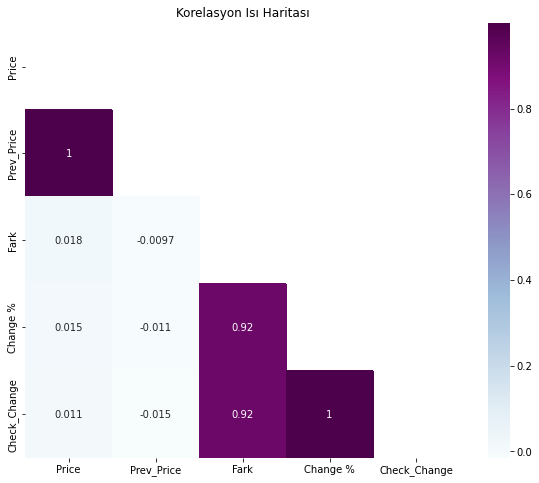

In [ ]:
plt.subplots(figsize=(10,8))
mask = np.zeros_like(df_chg.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_chg.corr(), cmap="BuPu", annot=True,
           square=True, mask=mask)
plt.title("Korelasyon Isı Haritası");

Korelasyon İlişklerini İncelersek;
- Change ile Fark arasında **%92**'lik
- Change ile Check Change arasında **%100**'lük


ilişki olduğunu görebiliriz.

Change Değeri şuanki gün ile bir önceki günün farkı olduğu için aslında basit bir **diff** alma işlemi gibi düşünülebilir.
Görseller de bizi destekleyecektir.

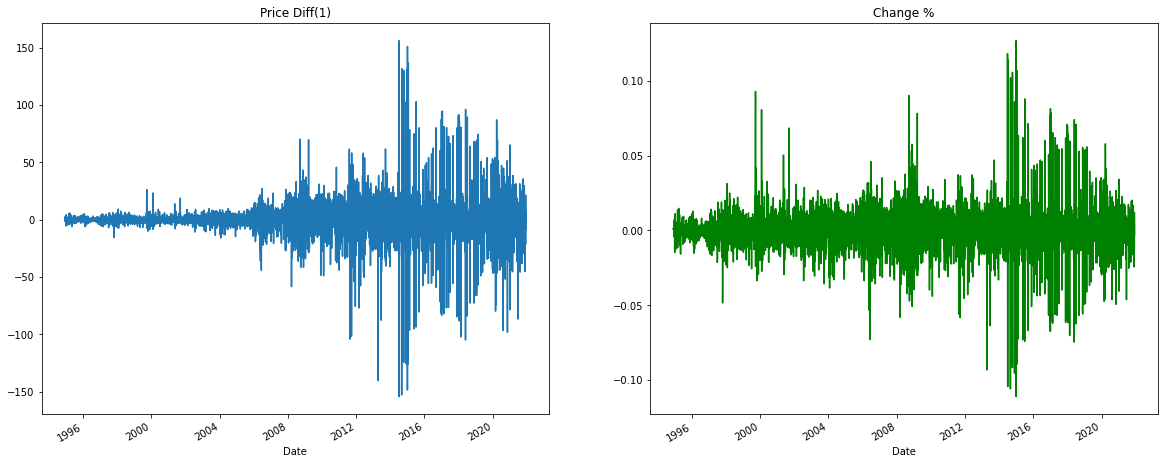

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.subplot(1, 2, 1)
df["Price"].diff().plot()
plt.title("Price Diff(1)")
plt.subplot(1, 2, 2)
df["Change %"].plot(color="green")
plt.title("Change %");

Bu çıkarım işlemini yapmamızın amacı bizim için hedef değişkene karar vermemize yardımcı olmasıdır.

Bir zaman serisi problemini tahmin ederken değerleri tahmin etmek yerine değişimi tahmin etmek daha faydalı olabilmektedir. Değişim tahmin edildiğinde fiyatın tahmin edilmesi de kaçınılmazdır.

In [ ]:
df

,Date,Price,Change %
Date,,,
1994-12-06,1994-12-06,375.80,0.0008
1994-12-07,1994-12-07,376.10,0.0008
1994-12-08,1994-12-08,376.60,0.0013
1994-12-09,1994-12-09,377.00,0.0011
1994-12-12,1994-12-12,377.50,0.0013
...,...,...,...
2021-12-01,2021-12-01,1784.30,0.0044
2021-12-02,2021-12-02,1762.70,-0.0121
2021-12-03,2021-12-03,1783.90,0.0120


In [ ]:
def date_features(df, label=None):
    df_period = df.copy()

    df_period['date'] = df.Date
    df_period['month'] = df['Date'].dt.strftime('%B')
    df_period['year'] = df['Date'].dt.strftime('%Y')
    df_period['dayofweek'] = df['Date'].dt.strftime('%A')
    df_period['quarter'] = df['Date'].dt.quarter
    df_period['dayofyear'] = df['Date'].dt.dayofyear
    df_period['dayofmonth'] = df['Date'].dt.day
    df_period['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df_period[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_period[label]
        return X, y
    return X

In [ ]:
X, y = date_features(df, label='Price')
df_new = pd.concat([X, y], axis=1)
df_new = df_new[df_new["year"]>"2016"]
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Price
Date,,,,,,,,
2017-01-02,Monday,1,January,2017,2,2,1,1151.05
2017-01-03,Tuesday,1,January,2017,3,3,1,1244.70
2017-01-04,Wednesday,1,January,2017,4,4,1,1247.10
2017-01-05,Thursday,1,January,2017,5,5,1,1262.10
2017-01-06,Friday,1,January,2017,6,6,1,1255.70


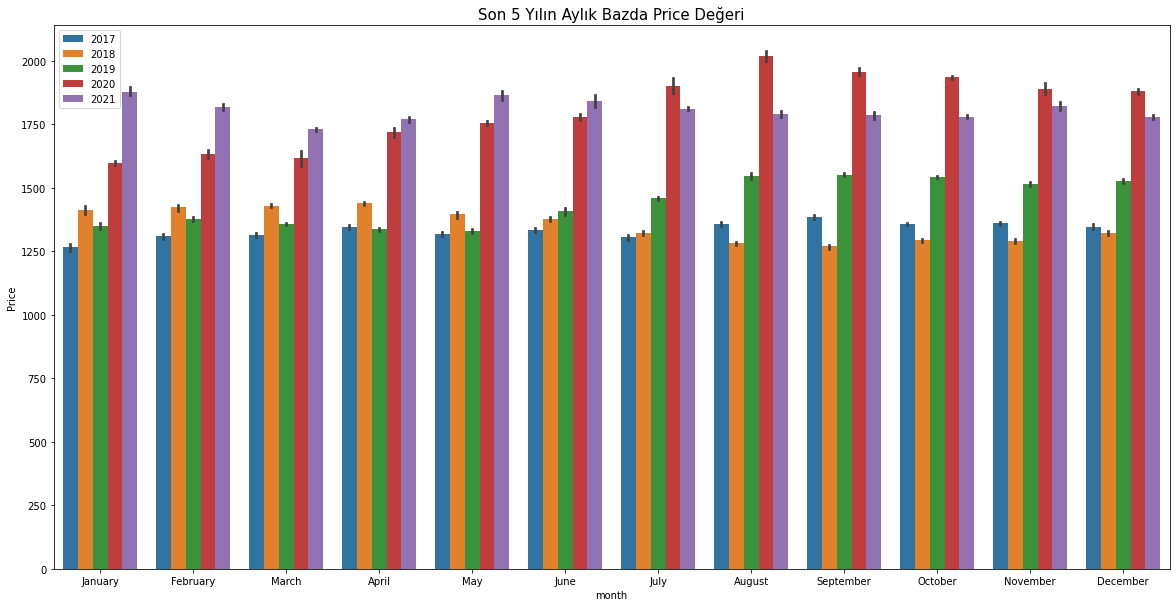

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Price",hue = 'year',data=df_new)
a.set_title("Son 5 Yılın Aylık Bazda Price Değeri",fontsize=15)
plt.legend(loc='upper left')
plt.show()

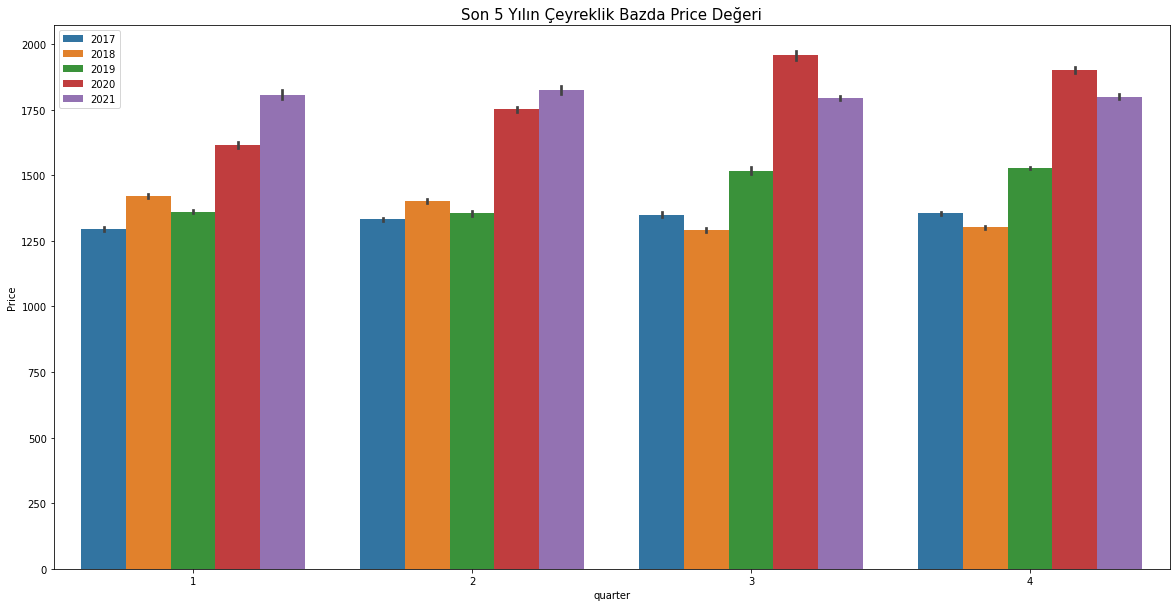

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="quarter", y="Price",hue = 'year',data=df_new)
a.set_title("Son 5 Yılın Çeyreklik Bazda Price Değeri",fontsize=15)
plt.legend(loc='upper left')
plt.show()

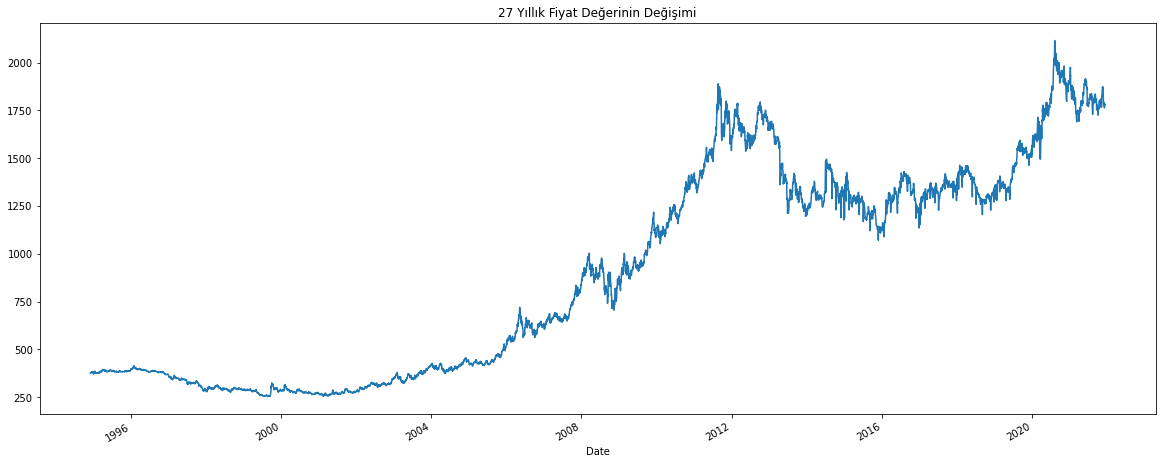

In [ ]:
df["Price"].plot()
plt.title("27 Yıllık Fiyat Değerinin Değişimi");

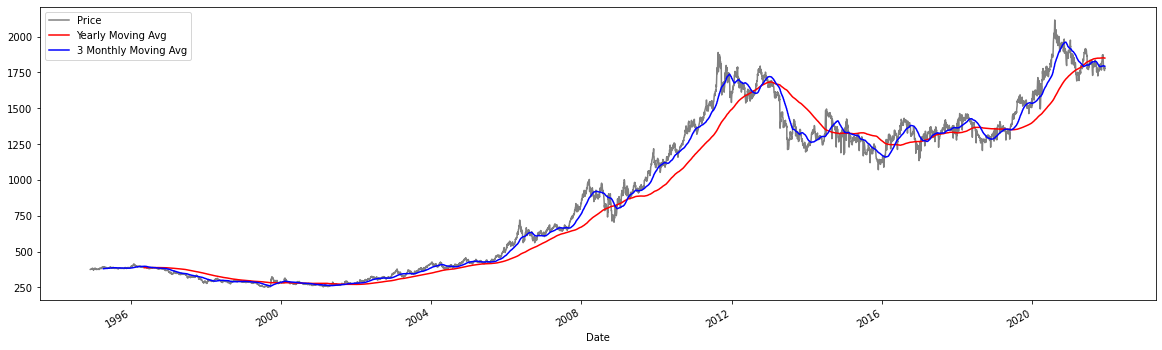

In [ ]:
moving_avg_3month = df["Price"].rolling(90).mean()
moving_avg_year = df["Price"].rolling(365).mean()
df["Price"].plot(figsize=(20, 6), label = "Price", legend=True, color ="gray")
moving_avg_year.plot(label = "Yearly Moving Avg",legend=True, color="red")
moving_avg_3month.plot(label = "3 Monthly Moving Avg",legend=True, color="blue");

## 3. Zaman Serisi Durağanlık Kontrolü <a id=3></a>

Bir dizinin durağan seri olarak sınıflandırılması için üç temel kriter vardır:

1.  Serinin ortalaması, zamanın bir fonksiyonu olmamalı, sabit olmalıdır. Aşağıdaki görüntü koşulu karşılayan sol taraftaki grafiğe sahipken, kırmızı grafik zamana bağlı bir ortalamaya sahiptir.
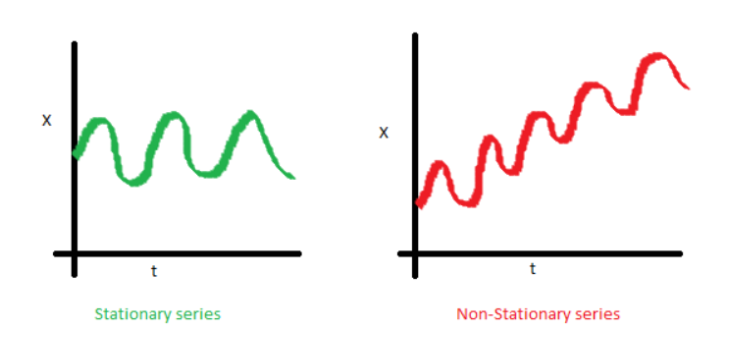

2. Serinin varyansı zamanın bir fonksiyonu olmamalıdır. Bu özellik, eş varyans olarak bilinir. Aşağıdaki grafik durağan bir dizinin ne olduğunu ve neyin olmadığını göstermektedir. (Sağ taraftaki grafikte değişen dağılım dağılımına dikkat edin)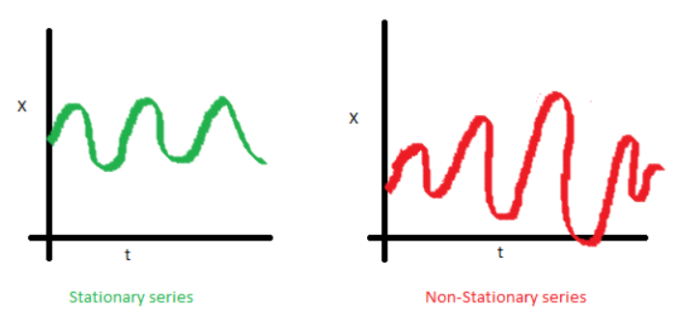

3. i. terimin ve (i + m). terimin kovaryansı, zamanın bir fonksiyonu olmamalıdır. Aşağıdaki grafikte, zaman arttıkça yayılmanın yaklaştığını göreceksiniz. Dolayısıyla kovaryans, "kırmızı dizi" için zamanla sabit değildir.
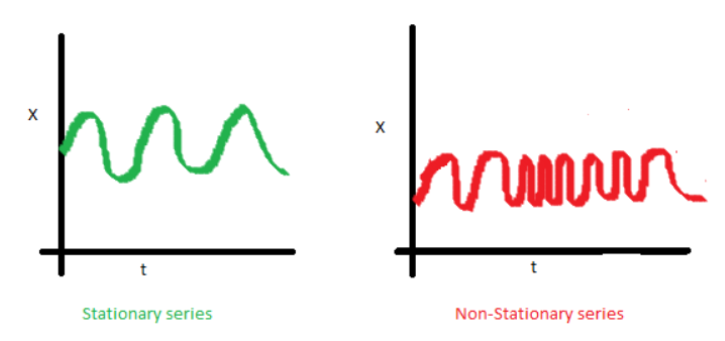

# **Bir zaman serisinin "durağanlığı" neden önemli?**
Bu bölümü özellikle ele almamızın sebebi, zaman serisi sabit/durağan olmadığı sürece bir zaman serisi modeli oluşturamayacağınızdır. Durağan kriterin ihlal edildiği durumlarda, ilk koşul, zaman serilerini durağanlaştırmak ve ardından bu zaman serisini tahmin etmek için stokastik modelleri denemek olur. Durağan olmayan bir zaman serisini, durağan hale getirmenin birçok yolu vardır.

### Dicky Fuller Testi <a id=31></a>

In [ ]:
def test_stationarity(data):
    
    '''
    Özet:
    -------
    Adfuller test  zaman serisinin zaman aralığında veri setinin durağan olup olmadığını gösterir.
    p_val >= 0.05 zaman serisinin durağan olmadığını gösteririr.
    '''

    p_val = adfuller(data)[1]
    
    if p_val >= 0.05:
        print("Zaman serisi durağan değildir. Adfuller test p-value={}".format(p_val))
    else:
        print("Zaman serisi durağandır. Adfuller test p-value={}".format(p_val))

In [ ]:
test_stationarity(df["Price"].shift().dropna())

Zaman serisi durağan değildir. Adfuller test p-value=0.9360069863536249


Veri setinin tamamına bakıldığında sürekli bir artış trendi mevcuttur. Artışın sürekli olması serinin durağanlığını bozmaktadır.

## 4. Model İçin Veri Setinin Hazırlanması <a id=4></a>

In [ ]:
df_monthly = df.resample("M").sum()

In [ ]:
df_monthly.drop(df_monthly.tail(1).index,axis=0,inplace=True)

In [ ]:
df_monthly.drop(df_monthly.head(1).index,axis=0,inplace=True)


###Train Test Split <a id=41></a>

In [ ]:
training_set = df_monthly.loc[:"2019-01-01","Price"].values
test_set = df_monthly.loc["2019-01-01":,"Price"].values
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)

Veri seti 3 yıllık test seti ve 24 yıllık train seti olarak ayrılmıştır.

In [ ]:
[training_set.shape, test_set.shape]

[(288, 1), (35, 1)]

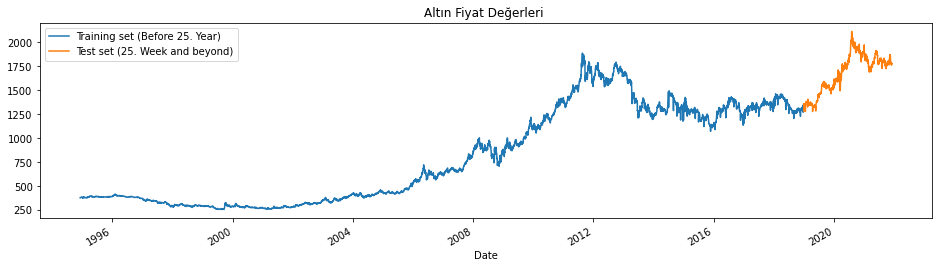

In [ ]:
df.loc[:"2019-01-01","Price"].plot(figsize=(16,4),legend=True)
df.loc["2019-01-01":,"Price"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 25. Year)','Test set (25. Week and beyond)'])
plt.title('Altın Fiyat Değerleri ')
plt.show()


###Scaling <a id=42></a>

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
def create_train(window, threshold):
    
    X_train = []
    y_train = []

    for i in range(window, threshold):
        X_train.append(training_set_scaled[i-window:i,0])
        y_train.append(training_set_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    return X_train, y_train

In [ ]:
X_train,y_train = create_train(12,len(training_set_scaled))

In [ ]:
def create_model(opt, ls, ep, btch_size):
    
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.5))
    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    # Fourth LSTM layer
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    # The output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer=opt,loss = ls)
    # Fitting to the training set
    regressor.fit(X_train,y_train,epochs=ep,batch_size=btch_size)
    return regressor

In [ ]:
model = create_model(opt ="rmsprop", ls = "mean_squared_error", ep = 20, btch_size = 32)

Epoch 1/20
9/9 [==============================] - 14s 34ms/step - loss: 0.0684
Epoch 2/20
9/9 [==============================] - 0s 34ms/step - loss: 0.0250
Epoch 3/20
9/9 [==============================] - 0s 33ms/step - loss: 0.0197
Epoch 4/20
9/9 [==============================] - 0s 34ms/step - loss: 0.0240
Epoch 5/20
9/9 [==============================] - 0s 34ms/step - loss: 0.0228
Epoch 6/20
9/9 [==============================] - 0s 34ms/step - loss: 0.0150
Epoch 7/20
9/9 [==============================] - 0s 33ms/step - loss: 0.0223
Epoch 8/20
9/9 [==============================] - 0s 36ms/step - loss: 0.0140
Epoch 9/20
9/9 [==============================] - 0s 32ms/step - loss: 0.0138
Epoch 10/20
9/9 [==============================] - 0s 34ms/step - loss: 0.0173
Epoch 11/20
9/9 [==============================] - 0s 35ms/step - loss: 0.0147
Epoch 12/20
9/9 [==============================] - 0s 36ms/step - loss: 0.0179
Epoch 13/20
9/9 [==============================] - 0s 36ms/s

In [ ]:
dataset_total = pd.concat((df_monthly.loc[:"2018-12-31","Price"], df_monthly.loc["2019-01-01":,"Price"]),axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) -12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
inputs.shape

(47, 1)

In [ ]:
test_set.shape

(35, 1)

In [ ]:
def create_test(window, size):

    X_test = []

    for i in range(window, size):
        X_test.append(inputs[i-12:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    return X_test

In [ ]:
X_test = create_test(12, len(inputs))

In [ ]:
X_test

array([[[0.81676461],
        [0.70295078],
        [0.70686494],
        [0.71236835],
        [0.80398885],
        [0.67523439],
        [0.68069568],
        [0.69205909],
        [0.61227372],
        [0.69874741],
        [0.66212168],
        [0.64281342]],

       [[0.70295078],
        [0.70686494],
        [0.71236835],
        [0.80398885],
        [0.67523439],
        [0.68069568],
        [0.69205909],
        [0.61227372],
        [0.69874741],
        [0.66212168],
        [0.64281342],
        [0.7731122 ]],

       [[0.70686494],
        [0.71236835],
        [0.80398885],
        [0.67523439],
        [0.68069568],
        [0.69205909],
        [0.61227372],
        [0.69874741],
        [0.66212168],
        [0.64281342],
        [0.7731122 ],
        [0.67620029]],

       [[0.71236835],
        [0.80398885],
        [0.67523439],
        [0.68069568],
        [0.69205909],
        [0.61227372],
        [0.69874741],
        [0.66212168],
        [0.64281342],
    

In [ ]:
X_test.shape

(35, 12, 1)

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
len(predicted_stock_price)

35

In [ ]:
df_monthly

,Price,Change %
Date,,
1995-01-31,7947.1,-0.0199
1995-02-28,7164.1,0.0040
1995-03-31,8800.2,0.0404
1995-04-30,7437.6,-0.0133
1995-05-31,8486.8,-0.0047
...,...,...
2021-07-31,41629.4,0.0235
2021-08-31,39388.5,0.0016
2021-09-30,41039.8,-0.0335


In [ ]:
predicted_stock_price.shape

(35, 1)

In [ ]:
test_set.shape

(35, 1)

In [ ]:
tr = pd.DataFrame(training_set)
ts = pd.DataFrame(test_set)
df_original = pd.concat([tr,ts])

In [ ]:
df_original

,0
0,7947.1
1,7164.1
2,8800.2
3,7437.6
4,8486.8
...,...
30,41629.4
31,39388.5
32,41039.8
33,37366.6


In [ ]:
df_original.reset_index(inplace=True)

In [ ]:
tr = pd.DataFrame(training_set)
ts = pd.DataFrame(predicted_stock_price)
df_pred = pd.concat([tr,ts])

In [ ]:
df_pred.reset_index(inplace = True)
df_pred

,index,0
0,0,7947.100000
1,1,7164.100000
2,2,8800.200000
3,3,7437.600000
4,4,8486.800000
...,...,...
318,30,37522.644531
319,31,37351.203125
320,32,37243.851562
321,33,36941.578125


In [ ]:
df_all = pd.concat([df_original, df_pred], axis = 1)
df_all.columns = [0,'actual', 0, 'pred']
df_all

,0,actual,0,pred
0,0,7947.1,0,7947.100000
1,1,7164.1,1,7164.100000
2,2,8800.2,2,8800.200000
3,3,7437.6,3,7437.600000
4,4,8486.8,4,8486.800000
...,...,...,...,...
318,30,41629.4,30,37522.644531
319,31,39388.5,31,37351.203125
320,32,41039.8,32,37243.851562
321,33,37366.6,33,36941.578125


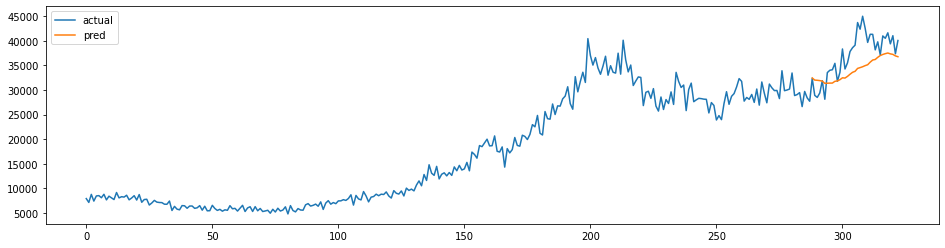

In [ ]:
df_all["actual"].plot(figsize=(16,4),legend=True)
df_all["pred"].loc[288:].plot(figsize=(16,4),legend=True)

In [1]:
RMSE:4123.0